In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/SDSC_ISG-TrendModel'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

27

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,location,target,type,quantile,forecast_date,target_end_date,value
39,42,1 wk ahead inc case,point,NaN,2021-09-05,2021-09-11,29294.125052
39,42,1 wk ahead inc case,point,NaN,2021-09-12,2021-09-18,31375.838768
39,42,1 wk ahead inc case,point,NaN,2021-09-19,2021-09-25,33252.407737
39,42,1 wk ahead inc case,point,NaN,2021-09-26,2021-10-02,29362.570733
39,42,1 wk ahead inc case,point,NaN,2021-10-03,2021-10-09,31476.545852


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [ ]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(27, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,location,target,type,quantile,forecast_date,value,dayRate
0,2021-09-11,42,1 wk ahead inc case,point,NaN,2021-09-05,29294.125052,4184.875007
1,2021-09-18,42,1 wk ahead inc case,point,NaN,2021-09-12,31375.838768,4482.262681
2,2021-09-25,42,1 wk ahead inc case,point,NaN,2021-09-19,33252.407737,4750.343962
3,2021-10-02,42,1 wk ahead inc case,point,NaN,2021-09-26,29362.570733,4194.652962
4,2021-10-09,42,1 wk ahead inc case,point,NaN,2021-10-03,31476.545852,4496.649407


In [15]:
df_weekly.tail(5)

,Date,location,target,type,quantile,forecast_date,value,dayRate
19,2022-01-29,42,1 wk ahead inc case,point,NaN,2022-01-23,93360.858284,13337.265469
20,2022-02-05,42,1 wk ahead inc case,point,NaN,2022-01-30,69926.638733,9989.519819
21,2022-02-12,42,1 wk ahead inc case,point,NaN,2022-02-06,28262.299745,4037.471392
22,2022-02-19,42,1 wk ahead inc case,point,NaN,2022-02-13,20295.801382,2899.400197
23,2022-02-26,42,1 wk ahead inc case,point,NaN,2022-02-20,15093.077460,2156.153923


In [13]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[4184.875007369557, 4184.875007369557, 4184.875007369557, 4184.875007369557, 4184.875007369557, 4184.875007369557, 4184.875007369557, 4482.262681178643, 4482.262681178643, 4482.262681178643, 4482.262681178643, 4482.262681178643, 4482.262681178643, 4482.262681178643, 4750.3439624089715, 4750.3439624089715, 4750.3439624089715, 4750.3439624089715, 4750.3439624089715, 4750.3439624089715, 4750.3439624089715, 4194.652961806257, 4194.652961806257, 4194.652961806257, 4194.652961806257, 4194.652961806257, 4194.652961806257, 4194.652961806257, 4496.6494073964, 4496.6494073964, 4496.6494073964, 4496.6494073964, 4496.6494073964, 4496.6494073964, 4496.6494073964, 5485.850407455943, 5485.850407455943, 5485.850407455943, 5485.850407455943, 5485.850407455943, 5485.850407455943, 5485.850407455943, 4195.7880382457, 4195.7880382457, 4195.7880382457, 4195.7880382457, 4195.7880382457, 4195.7880382457, 4195.7880382457, 3326.6147073783, 3326.6147073783, 3326.6147073783, 3326.6147073783, 3326.6147073783, 3326

In [14]:
len(predictions)

168

In [18]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2021-09-11') & (df1['Date'] <= '2022-02-25')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2021-09-11,7566,8162.2,2720510,25603978,2497.7,2692.8,727156.8,2860489,-5275.682283,2774.207671
1,2021-09-12,6262,8345.7,2726772,25603978,1799.2,2748.8,728956.2,2860489,-5275.682283,2774.207671
2,2021-09-13,9462,9035.4,2736234,25603978,3517.9,3068.4,732474.0,2860489,-5275.682283,2774.207671
3,2021-09-14,8068,8749.7,2744302,25603978,2668.9,2966.2,735143.3,2860489,-5275.682283,2774.207671
4,2021-09-15,12578,9305.2,2756880,25603978,4785.6,3233.0,739928.2,2860489,-5275.682283,2774.207671


In [19]:
len(df1_copy)

168

In [20]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [22]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [23]:
merged_df_new.shape

(168, 12)

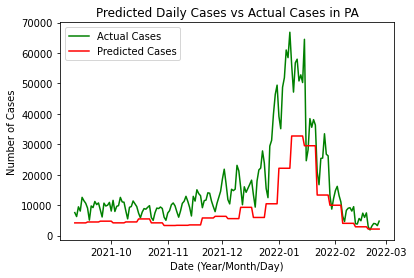

In [24]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [25]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

164
0.9761904761904762
4
0.023809523809523836
168
[0.4468840857296382, 0.3317031288135488, 0.5577177121782332, 0.481299577668622, 0.667286133934683, 0.6352732257826776, 0.6060923374087389, 0.5049411662051422, 0.12146948624487591, 0.5400920704721277, 0.5132208208971935, 0.6005113474885345, 0.5604763011199605, 0.5828124831367607, 0.4342134394462873, 0.22481332206119917, 0.5550445895083391, 0.5116833920221041, 0.5248705778746778, 0.5650664747840165, 0.41194058400483147, 0.6382048506290964, 0.47143989896594546, 0.5646893979030452, 0.5745788071190409, 0.6662433989651292, 0.6210107551674867, 0.6181124397481558, 0.4467704961372539, 0.18331830595779142, 0.5166971832119088, 0.5295407608917765, 0.6051414289255005, 0.5699455425213849, 0.5286531019500629, 0.2572636870490193, 0.06480559027344984, 0.29123379748631223, 0.38236316061067965, 0.36900731453232766, 0.4103772133000921, 0.4433999180746811, 0.2931623924788242, 0.16151318180541574, 0.44100878787027714, 0.5362745315820403, 0.5280328415921598, 

In [26]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.5531159142703618, 0.6682968711864512, 0.4422822878217668, 0.518700422331378, 0.33271386606531705, 0.36472677421732236, 0.3939076625912611, 0.4950588337948578, 0.878530513755124, 0.4599079295278723, 0.48677917910280655, 0.3994886525114655, 0.4395236988800395, 0.4171875168632393, 0.5657865605537127, 0.7751866779388008, 0.4449554104916609, 0.4883166079778959, 0.47512942212532217, 0.4349335252159835, 0.5880594159951685, 0.3617951493709036, 0.5285601010340546, 0.4353106020969548, 0.42542119288095914, 0.3337566010348708, 0.3789892448325133, 0.3818875602518442, 0.5532295038627462, 0.8166816940422086, 0.48330281678809117, 0.4704592391082235, 0.3948585710744995, 0.43005445747861515, 0.4713468980499371, 0.7427363129509807, 0.9351944097265501, 0.7087662025136878, 0.6176368393893203, 0.6309926854676724, 0.589622786699908, 0.556600081925319, 0.7068376075211757, 0.8384868181945843, 0.5589912121297229, 0.4637254684179597, 0.4719671584078402, 0.4461705697836771, 0.4700636386114384, 0.54858421955446

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

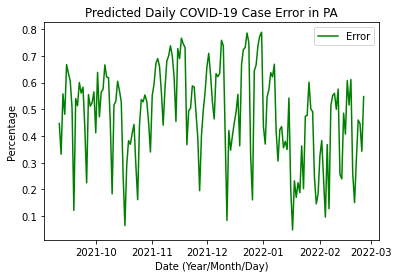

In [28]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

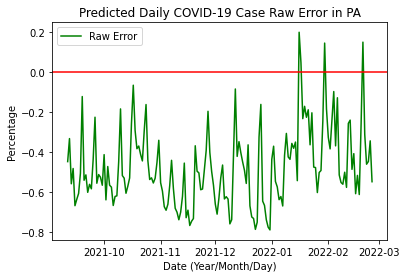

In [29]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

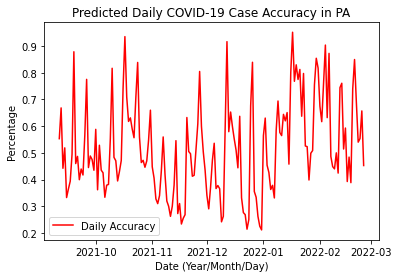

In [30]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [31]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [32]:
len(weeklyDateList)

25

In [34]:
del weeklyDateList[-1:]
len(averageWeeklyAccuracy)

24

In [35]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

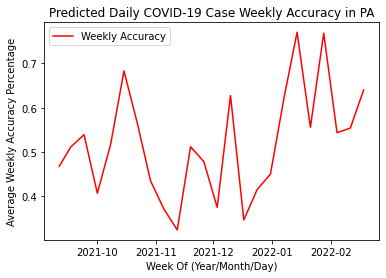

In [36]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [37]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [38]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

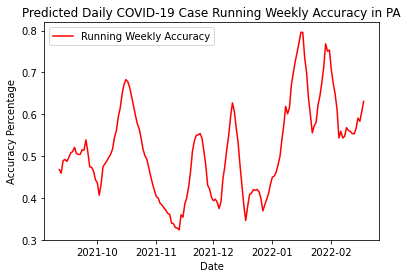

In [39]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

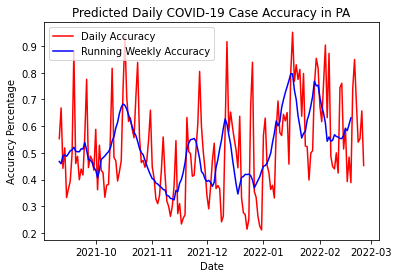

In [40]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [41]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [42]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

6

In [43]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

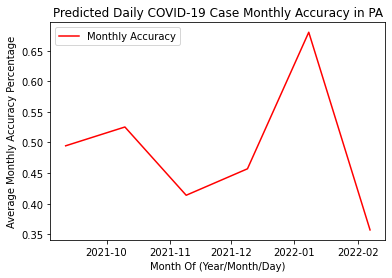

In [44]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [45]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [46]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

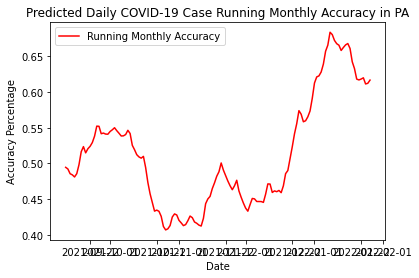

In [47]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [48]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [49]:
print(averageYearlyAccuracy)

[0.5196359642060998]


In [52]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.5196359642060998


In [53]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [54]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [55]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
113,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,22137.923612,0.369793,0.630207,-0.369793
114,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,22137.923612,0.546056,0.453944,-0.546056
115,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,22137.923612,0.573434,0.426566,-0.573434
116,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,22137.923612,0.637107,0.362893,-0.637107
117,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,22137.923612,0.621522,0.378478,-0.621522


([<matplotlib.axis.XTick at 0x7f0d4700bf50>,
 <a list of 8 Text major ticklabel objects>)

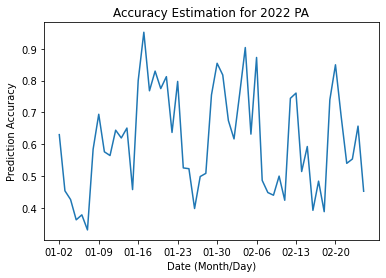

In [56]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [57]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.5531159142703618, 0.6682968711864512, 0.4422822878217668, 0.518700422331378, 0.33271386606531705, 0.36472677421732236, 0.3939076625912611, 0.4950588337948578, 0.878530513755124, 0.4599079295278723, 0.48677917910280655, 0.3994886525114655, 0.4395236988800395, 0.4171875168632393, 0.5657865605537127, 0.7751866779388008, 0.4449554104916609, 0.4883166079778959, 0.47512942212532217, 0.4349335252159835, 0.5880594159951685, 0.3617951493709036, 0.5285601010340546, 0.4353106020969548, 0.42542119288095914, 0.3337566010348708, 0.3789892448325133, 0.3818875602518442, 0.5532295038627462, 0.8166816940422086, 0.48330281678809117, 0.4704592391082235, 0.3948585710744995, 0.43005445747861515, 0.4713468980499371, 0.7427363129509807, 0.9351944097265501, 0.7087662025136878, 0.6176368393893203, 0.6309926854676724, 0.589622786699908, 0.556600081925319, 0.7068376075211757, 0.8384868181945843, 0.5589912121297229, 0.4637254684179597, 0.4719671584078402, 0.4461705697836771, 0.4700636386114384, 0.54858421955446

In [58]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.0300780824053222
0.1734303387684006


In [59]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4959091676830135


In [60]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [61]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [71]:
merged_df_new.index[merged_df_new['Date']=='2021-09-11'].tolist()

[0]

In [72]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[81]

In [74]:
#print(merged_inner)
deltaVariantDF = merged_df_new[0:81]
omicronVariantDF = merged_df_new[81:]

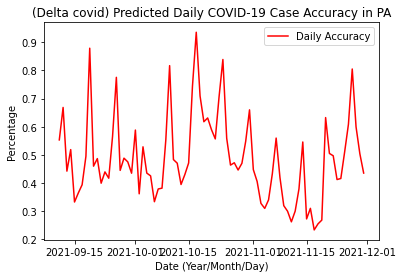

In [75]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

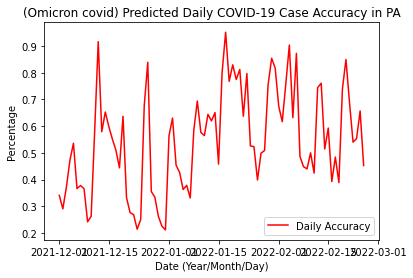

In [76]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()